<a href="https://colab.research.google.com/github/storimaging/Notebooks/blob/main/Restoration/Non_local_approaches_for_image_denoising.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Non local approaches for image denoising

## Introduction

The subject of these exercises is patch-based image denoising. Assume that we observe a noisy $n \times n$ image $v = u + b,$ with $b$ an additive gaussian noise (assumed to be i.i.d  $\mathcal{N}$(0,$\sigma^2$)). Our goal is to recover $u$ from the values of $v$. Non local methods try to solve the inverse problem of recovering $u$ from $v$ by performing some kind of regularization in the patch space. Patches are small images extracted from $v$. In the following we will consider square patches of size $(2f+1)\times (2f+1)$.

**Authors:**
* [Julie Delon](https://github.com/judelo)
* Lucía Bouza


## Importing packages

Below is a list of packages needed to implement Non Local approaches for image denoising.

- `matplotlib.pyplot, BytesIO, urlopen` (load and display images)
- `view_as_windows` (patch extraction)
- `dct, idct` (Discrete Cosine Transform and inverse Discrete Cosine Transform)

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from io import BytesIO
from urllib.request import urlopen
from skimage.util import view_as_windows
from scipy.fftpack import dct, idct
%matplotlib inline

To import the solutions, execute the following cell.

In [ ]:
#@title
import numpy as np
from skimage.util import view_as_windows

def moyCov(Y):
    
    mY = np.mean(Y, axis=1)
    C = np.cov(Y)
    Yc = (Y.T - mY.T).T
    return mY,C,Yc


def denoisePCA(Y,eta):
    
    # PCA
    mY,C,Yc = moyCov(Y)
    D, X = np.linalg.eig(C)
    idx = D.argsort()[::-1] 
    D = D[idx]
    X = X[:,idx]
    
    # Hard thresholding     
    Yproj = np.dot(X.T,Yc)                       
    Yproj[np.abs(Yproj)<eta] = 0  
    
    Z = np.dot(X, Yproj) + mY[:, np.newaxis]

    return Z


def denoisePCAsoft(Y,eta):
    
    # PCA
    mY,C,Yc = moyCov(Y)
    D, X = np.linalg.eig(C)
    idx = D.argsort()[::-1] 
    D = D[idx]
    X = X[:,idx]
    
    # Soft thresholding 
    Yproj= np.dot(X.T,Yc)  
    Yproj = np.sign(Yproj)*np.maximum(0, np.abs(Yproj) - eta)
    
    Z = np.dot(X, Yproj) + mY[:, np.newaxis]
    
    return Z


def Patch_Extraction(f, v):
    
    patch_shape = (2*f+1, 2*f+1)
    return view_as_windows(v, patch_shape).reshape(-1, patch_shape[0]*patch_shape[1]).T[:,::]


def Image_Reconstruction2(Ydenoised, nrow, ncol, f):
    
    tmp = np.zeros(shape=(nrow, ncol,(2*f+1)*(2*f+1)))
    count = np.zeros(shape=(nrow, ncol))
    
    # For iter in rows of Ydenoised
    i = 0    
    for x in range(2*f+1):
        for y in range(2*f+1):   
            w = Ydenoised[i,:].reshape(nrow-2*f,ncol-2*f)    # Extract image of row i
            tmp[x:nrow-2*f+x, y:ncol-2*f+y,i] = w    # Put on channel i of tmp the image with int the correct position   
            count [x:nrow-2*f+x, y:ncol-2*f+y] += 1    # Indicate on count the pixels contained in the image w. it will be necessary for calculate average
            i += 1

    return np.divide(np.sum(tmp,axis=2), count)


def PCADenoising(f, v, sigma, denoise):

    nrow, ncol = v.shape

    # Decomposition of v into Patches Y
    Y = Patch_Extraction(f, v)
    
    # PCA of Y and hard thresholding
    eta = 3*sigma 
    Z = denoise(Y,eta)

    # Reconstruction of vdenoised
    vdenoised = Image_Reconstruction2(Z, nrow, ncol, f)
    return vdenoised


def CutImage(lengthSquare, v,step):
    
    square_shape = (lengthSquare, lengthSquare)
    return view_as_windows(v, square_shape, step)


def PCADenoisingLocalization(f, v, sigma, denoise, step, length):

    nrow, ncol = v.shape
    eta = 3*sigma

    imageRectangles = CutImage(length, v, step)
    tmp = np.zeros(shape=(nrow, ncol, imageRectangles.shape[0]*imageRectangles.shape[1]))
    count = np.zeros(shape=(nrow, ncol))
    aux = 0

    for i in range(imageRectangles.shape[0]):
        for j in range(imageRectangles.shape[1]):
            # Decomposition of v into Patches Y
            Y = Patch_Extraction(f, imageRectangles[i,j,:,:])

            # PCA of Y and hard thresholding    
            Z = denoise(Y,eta)

            # Reconstruction of vdenoised
            vdenoised = Image_Reconstruction2(Z, imageRectangles.shape[2], imageRectangles.shape[3], f)

            x_pos, y_pos = i*step, j*step
        
            # Put on channel aux of tmp the image with int the correct position  
            tmp  [x_pos:length +x_pos, y_pos:length+y_pos, aux] = vdenoised 
        
            # Indicate on count the pixels contained in the image w. it will be necessary for calculate average
            count[x_pos:length +x_pos, y_pos:length+y_pos] += 1  
        
            aux += 1

    vdenoised = np.divide(np.sum(tmp,axis=2), count)
    return vdenoised

## Load and display images

A color image is made of three channels: red, green and blue. A color image in $\mathbb{R}^{N\times M}$ is stored as a $N\times M\times 3$ matrix.

    
**Be careful with the functions `plt.imread()` and `plt.imshow()` of `matplotlib`.** 
- `plt.imread()` reads png images as numpy arrays of floating points between 0 and 1, but it reads jpg or bmp images as numpy arrays of 8 bit integers. 

- In this practical session, we assume images are encoded as floating point values between 0 and 1, so if you load a jpg or bmp file you must convert the image to float type and normalize its values to $[0,1]$.

- If 'im' is an image encoded as a float numpy array, `plt.imshow(im)` will display all values above 1 in white and all values below 0 in black. If the 'im' image is 8-bit encoded, `plt.imshow(im)` will display 0 in black and 255 in white.



Start by creating the noisy image $v$ by adding a gaussian noise image to an known image $u$.

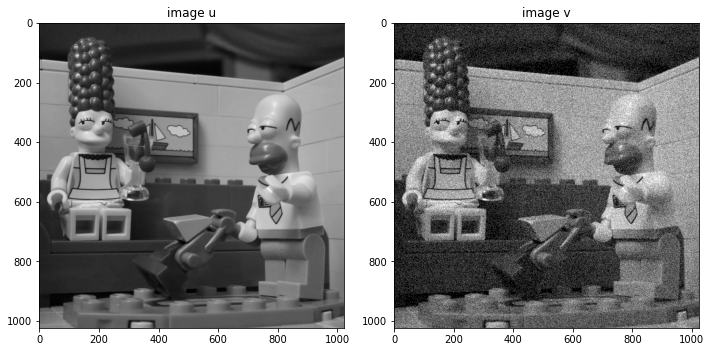

In [ ]:
# Noise standard deviation
sigma = 50/255

# Read image
IMG = "https://raw.githubusercontent.com/storimaging/Images/main/img/simpson.png"
u = plt.imread(BytesIO(urlopen(IMG).read()))

# for transform RGB images into black and white run the following line: u = (0.21*u[:,:,0] + 0.72*u[:,:,1] + 0.07*u[:,:,2])
# for jpg and bmp images you may need also run the following line: u = u/255

# Calculate noise
nrow,ncol = u.shape
b = sigma*np.random.randn(nrow,ncol)
v = u + b                                         

def printImages(a, b, title_a, title_b, size1, size2):

    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(size1, size1))
    axes[0].set_title(title_a)
    axes[0].imshow(a,cmap='gray',vmin=0,vmax=1)
    axes[1].set_title(title_b)
    axes[1].imshow(b,cmap='gray',vmin=0,vmax=1)
    fig.tight_layout()
    plt.show()

# Display images
printImages(u, v, 'image u', 'image v', 10, 10)

## 1 Patch extraction and image reconstruction

### 1.1 Patch extraction

The first step of a patch-based restoration method consists in extracting all sliding patches from the degraded image $v$. The patches here are all square images of size $(2f+1)\times (2f+1)$. (e.g $7\times 7$ if $f = 3$) extracted from $v$. 

In Python, we can use the function `view_as_windows` to extract all the image patches. Then is necessary to rearrange them into columns in a huge matrix. Beware of the fact that the resulting matrix will have $(2f+1)\times (2f+1)$ rows but only $(n-2f)\times(m-2f)$ columns since only patches completely included in $v$ are extracted.


In [ ]:
def Patch_Extraction(f, v):
    
    patch_shape = (2*f+1, 2*f+1)
    return view_as_windows(v, patch_shape).reshape(-1, patch_shape[0]*patch_shape[1]).T[:,::]

f = 3
Y = Patch_Extraction(f, v)

# Print shapes
print("Shape v:", v.shape)
print("Shape Y:", Y.shape)

Shape v: (1024, 1024)
Shape Y: (49, 1036324)


### 1.2 Image reconstruction

The goal of the following sections is to study several methods to denoise the patches in the matrix $Y$. Once the matrix $Y$ is denoised at $Ydenoised$, there are several ways to reconstruct the denoised image $u$. First, we can simply extract a row $k$ of $Ydenoised$ (explain why):

In [ ]:
def Image_Reconstruction1(k, Ydenoised, nrow, ncol, f):
    
    return Ydenoised[k,:].reshape(nrow-2*f,ncol-2*f)

Each line of $Ydenoised$ yields a denoised version of $v$ but shifted in space. In order to denoise $v$ a little further, we can average all these denoised versions, after correcting their relative shifts.

In [ ]:
def Image_Reconstruction2(Ydenoised, nrow, ncol, f):
    
    tmp = np.zeros(shape=(nrow, ncol,(2*f+1)*(2*f+1)))
    count = np.zeros(shape=(nrow, ncol))
    
    # For iter in rows of Ydenoised
    i = 0    
    for x in range(2*f+1):
        for y in range(2*f+1):   
            w = Ydenoised[i,:].reshape(nrow-2*f,ncol-2*f)    # Extract image of row i
            tmp[x:nrow-2*f+x, y:ncol-2*f+y,i] = w    # Put on channel i of tmp the image with int the correct position   
            count [x:nrow-2*f+x, y:ncol-2*f+y] += 1    # Indicate on count the pixels contained in the image w. it will be necessary for calculate average
            i += 1

    return np.divide(np.sum(tmp,axis=2), count)

Explain the previous code. Try to decompose an image into its set of patches and to reconstruct it with the previous operations.

Shape vdenoised1:  (1018, 1018)
Shape vdenoised2:  (1024, 1024)


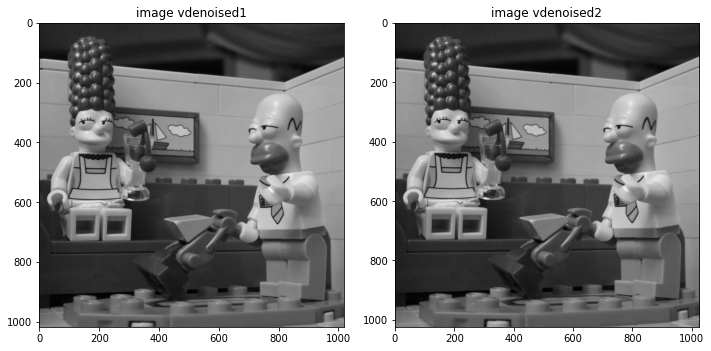

In [ ]:
# This code should give us a image u. 
# We choose the first row (k=0) but it could be any row.
Ydenoised = Patch_Extraction(f,u)
vdenoised1 = Image_Reconstruction1 (0, Ydenoised, nrow, ncol, f)
vdenoised2 = Image_Reconstruction2(Ydenoised, nrow, ncol, f)

# Print shapes of vdenoised1 and vdenoised2. 
# Look that vdenoised1 has shape nrow-2*f x ncol-2*f and vdenoised2 has nrow x ncol.
print("Shape vdenoised1: ", vdenoised1.shape)
print("Shape vdenoised2: ", vdenoised2.shape)

# Display images
printImages(vdenoised1, vdenoised2, 'image vdenoised1', 'image vdenoised2', 10, 10)

## 2 PCA-based denoising

This part concerns PCA image denoising. It is inspired by the paper

[*C.-A. Deledalle and J. Salmon and A. Dalalyan, Image denoising with patch based PCA: local versus global, proceedings of BMVC 2011.*](https://hal.inria.fr/hal-00654289/)

### 2.1 PCA

Once the patches are extracted, we consider them as a set of column vectors in $\mathbb{R}^{(2f+1)^2} : Y = (Y_1,\dots,Y_{nm})$. In order to remove the noise in $v$, we propose to threshold these vectors in a well chosen orthogonal basis. This basis is learned by applying a PCA to the set of vectors $(Y_1,\dots,Y_{nm})$.

To this aim, we compute the mean vector $mY$ and the covariance matrix $C$ for this set of vectors : $mY = \frac{1}{nm} \sum_{k=1}^{nm} Y_k, \;\; C = \frac{1}{nm} \sum_{k=1}^{nm} (Y_k-\bar{Y})(Y_k-\bar{Y})^t.$

Write a function `[moy,C,Yc]=moyCov(Y)` which computes the mean vector and covariance matrix of a set of column vectors $Y=(Y_1,\dots,Y_{nm})$. The function should also provide the centered matrix $Y_c = (Y_1-mY,\dots,Y_{nm}-mY)$.

In [ ]:
mY,C,Yc = moyCov(Y)

Principal component analysis (PCA) consists in computing the eigenvalues and eigenvectors of $C$. More precisely, if $\lambda_1 \geq \dots \geq \lambda_{(2f+1)^2}$ are the eigenvalues of $C$, and $X_1,\dots,X_{(2f+1)^2}$ the corresponding (normalized) eigenvectors, we call $X_k$ the $k-th$ the principal component of set of vectors $(Y_1,\dots,Y_{nm})$.

In this new basis $X$, each vector $Y_k$ can be rewritten as $Y_k = m_Y + Y_k - m_Y = m_Y + \sum_{i=1}^{(2*f+1)^2} X_i^t(Y_k-m_Y) X_i.$

Compute and display the orthonormal basis $X$ and the eigenvalues of the covariance matrix $C$. Display the eigenvalues in decreasing order. You can use the function `linalg.eig` of Python. The command `D, X = np.linalg.eig(C)` yields a diagonal matrix D of eigenvalues and a matrix X whose columns are the eigenvectors of C. Be careful that the eigenvalues in D are not ordered.

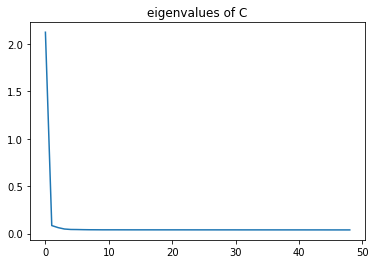

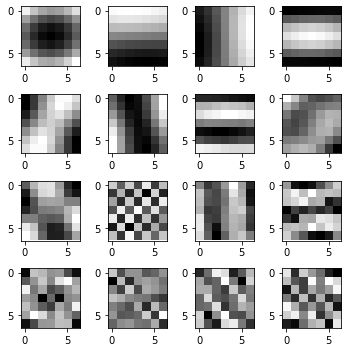

<Figure size 144x144 with 0 Axes>

<Figure size 144x144 with 0 Axes>

<Figure size 144x144 with 0 Axes>

<Figure size 144x144 with 0 Axes>

<Figure size 144x144 with 0 Axes>

<Figure size 144x144 with 0 Axes>

<Figure size 144x144 with 0 Axes>

<Figure size 144x144 with 0 Axes>

<Figure size 144x144 with 0 Axes>

<Figure size 144x144 with 0 Axes>

<Figure size 144x144 with 0 Axes>

<Figure size 144x144 with 0 Axes>

<Figure size 144x144 with 0 Axes>

<Figure size 144x144 with 0 Axes>

<Figure size 144x144 with 0 Axes>

<Figure size 144x144 with 0 Axes>

In [ ]:
# Compute eigen values and eigen vectors
D, X = np.linalg.eig(C)

idx = D.argsort()[::-1] 
D = D[idx]
X = X[:,idx]

# Plot eigenvalues in decreasing order
plt.title('eigenvalues of C')
plt.plot(D)

# Plot firsts eigenvectors 
fig, axes = plt.subplots(nrows=4, ncols=4, figsize=(5, 5), constrained_layout=False)
i = 0
for a in  axes.flat:
    plt.figure(figsize=(2, 2))
    a.imshow(X[:,i].reshape(2*f+1,2*f+1),'gray')
    i += 1

fig.tight_layout()
plt.show()

**Hard thresholding**:
 In order to denoise $Y_k$, we propose to threshold to $0$ all coefficients $X_i^t(Y_k-m_Y)$ smaller in norm that a given fixed threshold $\eta$. We then construct a new matrix $Z$ from $Y$. 

\begin{equation} 
Z_k = m_Y + \sum_{i=1}^{(2*f+1)^2} \phi\left(X_i^t(Y_k-m_Y)\right) X_i,
\end{equation}

where $\phi$ if the hard thresholding function

\begin{equation} 
\phi(t) = t.\mathbf{1}_{|t| > \eta}. 
\end{equation}

If we note $X$ the matrix of eigenvectors, this can be done easily with the following commands (Transpose of matrix are done for allowing broadcasting).

In [ ]:
eta = 3*sigma 

# Computation of all scalar products X_i^t(Y_k-m_Y)
Yproj = np.dot(X.T,Yc) 

# Hard thresholding
Yproj[np.abs(Yproj)<eta] = 0

# Reconstruction of the patches after hard thresholding
Z = np.dot(X, Yproj) + mY[:, np.newaxis]

Write a function `Z=denoisePCA(Y,eta)` which computes the PCA of $Y$ and apply the previous hard thresholding to its coefficients to denoise it.

In [ ]:
Z = denoisePCA(Y,eta)

**Soft thresholding**. The previous hard thresholding can be replaced by a smoother one, by replacing the function $\phi$ by the function


$$
\psi(t) = sign(t)*\max(0,|t|-\eta) = (t-\eta) * \mathbf{1}_{t > \eta} + (t+\eta) * \mathbf{1}_{t <- \eta}
$$


Write a function `Z=denoisePCAsoft(Y,eta)` which computes the PCA of $Y$ and apply the previous soft thresholding to its coefficients to denoise it.

In [ ]:
Z = denoisePCAsoft(Y,eta)

**PCA + thresholding + reconstruction**

We are now able to completely denoise an image, by applying the different steps studied above

- decomposition of $v$ into patches $Y$
- PCA analysis of $Y$, followed by hard or soft thresholding to obtain $Z$
- reconstruction of $vdenoised$ from $Z$

Write a function `vdenoised = PCADenoising(f, v, sigma, denoise)` where $f$ is the parameter for patch extraction, $v$ is the noisy image, $sigma$ is the noise standard deviation and $denoise$ can be one of two defined functions: `denoisePCA` or `denoisePCAsoft`. 

Test the whole method for several values of the noise standard deviation and several values of the threshold $\eta$. In order to evaluate the obtained results, you can compute the $L^2$ distance between the denoised image $vdenoised$ and the (known) input image $u$. Test the method for several images. Is there a connection between the standard deviation of the additive noise and the optimal parameter $\eta$ ?

You can use the follow auxiliary function to print the 3 images (u, v and vdenoised):

In [ ]:
#@title
def print3Images(u,v,vdenoised):
    
    fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(15, 15))
    axes[0].set_title('Original image')
    axes[0].imshow(u,cmap='gray',vmin=0,vmax=1)
    axes[1].set_title('Noisy image')
    axes[1].imshow(v,cmap='gray',vmin=0,vmax=1)
    axes[2].set_title('Denoised image')
    axes[2].imshow(vdenoised,cmap='gray',vmin=0,vmax=1)
    fig.tight_layout()
    plt.show()

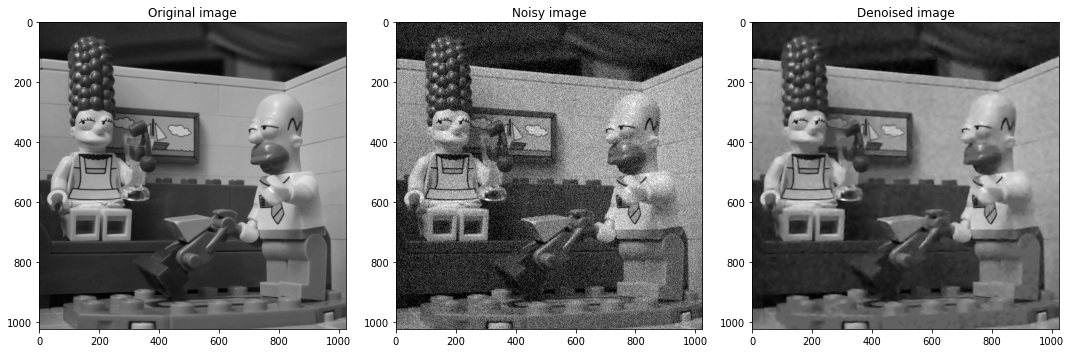

28.848260317180674


In [ ]:
vdenoised = PCADenoising(f=5, v=v, sigma=sigma, denoise= denoisePCA)

# Print results
print3Images(u,v,vdenoised)
dist = np.linalg.norm(u - vdenoised)
print(dist)

### 2.2 Localization

The previous method use a unique orthonormal basis to represent all patches in the whole image. In this sense, the method can be considered as global. In order to better adapt to the local image geometry, the method can be applied locally, for instance by cutting the image $v$ into rectangles.

Write a function which cut your image into overlapping rectangles (for instance $128\times 128$ squares) and apply the previous denoising method to all rectangles before reconstructing the whole image. Propose a solution to manage the overlapping areas.

Write a function `vdenoised = PCADenoisingLocalization(f, v, sigma, denoise, step, length)` where $f$ is the parameter for patch extraction, $v$ is the noisy image, $sigma$ is the noise standard deviation and $denoise$ can be one of two defined functions: `denoisePCA` or `denoisePCAsoft`. $length$ refers to the size of the rectangles and $step$ to the offset of overlapping. 

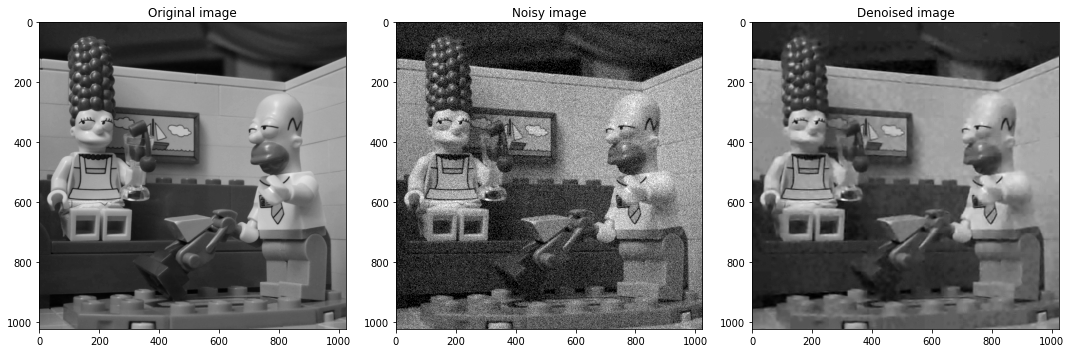

29.76456948947612


In [ ]:
length = 128
step = 64  # Paper suggest step = (length-1)/2

vdenoised = PCADenoisingLocalization(f= 5, v = v, sigma = sigma, denoise = denoisePCA, step = step, length = length)
   
# Print results
print3Images(u,v,vdenoised)
dist = np.linalg.norm(u - vdenoised)
print (dist)

## 3 DCT-based denoising

In the previous approach, the PCA basis can be replaced by a DCT orthogonal basis. All coefficients smaller than a given threshold $h$ in this basis are replaced by 0. See also the following IPOL demo : [*Guoshen Yu, and Guillermo Sapiro, DCT image denoising: a simple and effective image denoising algorithm, Image Processing On Line, 1 (2011).* ](https://www.ipol.im/pub/art/2011/ys-dct/)

The DCT thresholding denoising works better with larger patches (typically 15x15). If the following computations are too slow on your computer, try with a smaller image.

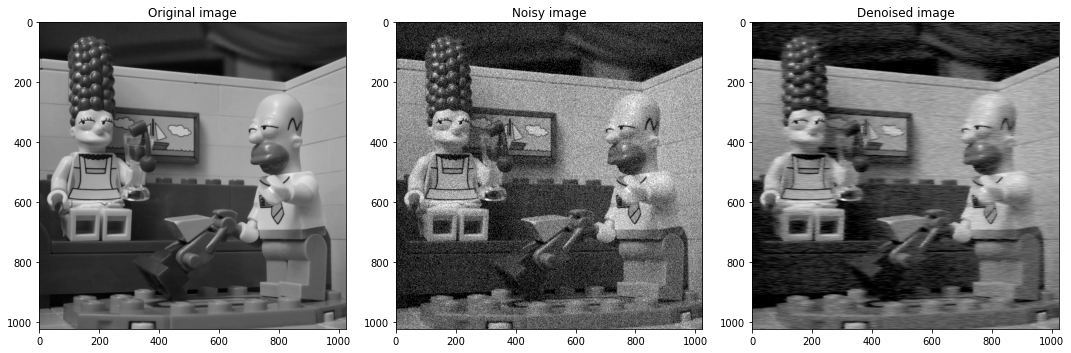

69.18691712872574


In [ ]:
f = 7
b = Patch_Extraction(f, v)
h = 3*sigma

# Reshape b into a stack of patches
b2d = b.reshape(2*f+1,2*f+1,-1) 
respatch = np.zeros(shape=b.shape)

for k in range(b2d.shape[2]):
    # Dct2 applied to each layer of b (each patch of image)
    tmp = dct(b2d[:,:,k],2, norm='ortho')
    # Threshold the dct coefficients
    tmp[np.abs(tmp)<h]=0     
    respatch[:,k] = idct(tmp, 2, norm='ortho').reshape((2*f+1)*(2*f+1))

vdenoised = Image_Reconstruction2(respatch, v.shape[0], v.shape[1], f)

# Print results
print3Images(u,v,vdenoised)
dist = np.linalg.norm(u - vdenoised)
print(dist)